In [1]:
import torch
from torch.utils.data import Dataset    # Dataset读取单个样本的抽象类，包括读取样本的标签、样本的索引、样本的特征
from torch.utils.data import DataLoader   # 数据加载器，组合数据集和采样器，并在数据集上提供单进程或多进程迭代器
from torchvision import datasets    # torchvision是PyTorch中专门用于图像处理的库,datasets是其中的数据集模块
from torchvision.transforms import ToTensor

from torch.nn import functional as F
from torch import nn, optim

import matplotlib.pyplot as plt

In [2]:
def plot_curve(data):
    """
    下降曲线的绘制
    :param data:
    :return:
    """
    # fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')  #range(len(data))用于生成一个从0到len(data)的整数序列表示横坐标，data表示纵坐标，color表示颜色
    plt.legend(['value'], loc='upper right')#图例，loc表示位置
    plt.xlabel('step')#横坐标
    plt.ylabel('value')#纵坐标
    plt.show()


def plot_image(img, label, name):
    # fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)     # 2行3列,i+1表示第几个子图
        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
        plt.imshow(img[i][0], cmap='gray', interpolation='none')  # img0维度存储的是图片，i是第i张图片。interpolation表示插值方法
        plt.title("{}: {}".format(name, label[i].item())) # 显示标题，label[i].item()表示取出label中的第i个元素，item()将tensor转换为标量，用于画图
        plt.xticks([])
        plt.yticks([])
    plt.show()


# def one_hot(label, depth=10):
#     """
#     one_hot编码
#     :param label:
#     :param depth:
#     :return:
#     """
#     out = torch.zeros(label.size(0), depth)
#     idx = torch.LongTensor(label).view(-1, 1)
#     out.scatter_(dim=1, index=idx, value=1)
#     return out


In [3]:
def load_dataset():
    #从torchversion加载自带数据集
    training_data = datasets.MNIST(
    root="data",    # 数据集存放路径
    train=True,    # 是否为训练集
    download=True,    # 是否下载
    transform=ToTensor(),    # 数据转换方式
    # transform=torchvision.transforms.Compose([  # 数据转换方式
    #     torchvision.transforms.ToTensor(),  # 将PIL.Image或numpy.ndarray转换为torch.FloatTensor，并归一化到[0,1]
    #     torchvision.transforms.Normalize(   # 标准化，均值为0，标准差为1
    #         (0.1307,), (0.3081,))   # 均值和标准差
    # ])
    )
    train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)    # DataLoader是一个迭代器，每次返回一个batch的数据
    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor()
    )

    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)  
    return train_dataloader, test_dataloader
#打印datasets支持的数据集
print(datasets.__all__)
    


('LSUN', 'LSUNClass', 'ImageFolder', 'DatasetFolder', 'FakeData', 'CocoCaptions', 'CocoDetection', 'CIFAR10', 'CIFAR100', 'EMNIST', 'FashionMNIST', 'QMNIST', 'MNIST', 'KMNIST', 'StanfordCars', 'STL10', 'SUN397', 'SVHN', 'PhotoTour', 'SEMEION', 'Omniglot', 'SBU', 'Flickr8k', 'Flickr30k', 'Flowers102', 'VOCSegmentation', 'VOCDetection', 'Cityscapes', 'ImageNet', 'Caltech101', 'Caltech256', 'CelebA', 'WIDERFace', 'SBDataset', 'VisionDataset', 'USPS', 'Kinetics', 'HMDB51', 'UCF101', 'Places365', 'Kitti', 'INaturalist', 'LFWPeople', 'LFWPairs', 'KittiFlow', 'Sintel', 'FlyingChairs', 'FlyingThings3D', 'HD1K', 'Food101', 'DTD', 'FER2013', 'GTSRB', 'CLEVRClassification', 'OxfordIIITPet', 'PCAM', 'Country211', 'FGVCAircraft', 'EuroSAT', 'RenderedSST2', 'Kitti2012Stereo', 'Kitti2015Stereo', 'CarlaStereo', 'Middlebury2014Stereo', 'CREStereo', 'FallingThingsStereo', 'SceneFlowStereo', 'SintelStereo', 'InStereo2k', 'ETH3DStereo')


In [4]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # xw + b
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1 + b)
        input=x #保存输入
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2 + b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3 + b3
        x = self.fc3(x)

        return x

In [5]:
def train(epoch_num, train_loader, net, optimizer):
    train_loss = []
    for epoch in range(epoch_num):
        for batch_idx, (x, y) in enumerate(train_loader):
            # x: [b, 1, 28, 28], y: [512]
            # [b, 1, 28, 28] => [b, feature]
            x = x.view(x.size(0), 28 * 28)
            # => [b, 10]
            out = net(x)
            # y_onehot = one_hot(y) # [b] => [b, 10]
            y_onehot = F.one_hot(y, 10).float()
            # loss = mse(out, y_onehot)
            loss = F.mse_loss(out, y_onehot)
            # print(loss)
            optimizer.zero_grad()
            loss.backward()
            # w' = w - lr * grad
            optimizer.step()

            train_loss.append(loss.item())

            if batch_idx % 100 == 0:
                print('epoch {}, batch_idx {}, loss {}'.format(epoch, batch_idx, loss.item()))

    return train_loss

epoch 0, batch_idx 0, loss 0.11146046966314316
epoch 0, batch_idx 100, loss 0.08033277094364166
epoch 0, batch_idx 200, loss 0.07152032852172852
epoch 0, batch_idx 300, loss 0.05897929519414902
epoch 0, batch_idx 400, loss 0.0581180639564991
epoch 0, batch_idx 500, loss 0.04517088085412979
epoch 0, batch_idx 600, loss 0.040778517723083496
epoch 0, batch_idx 700, loss 0.0479147806763649
epoch 0, batch_idx 800, loss 0.04804026708006859
epoch 0, batch_idx 900, loss 0.037839747965335846


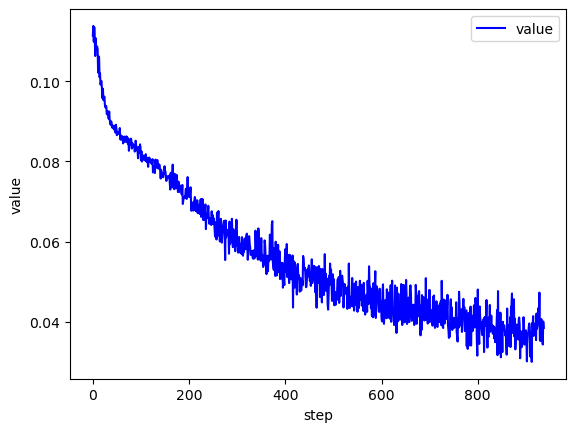

test acc: 0.8644


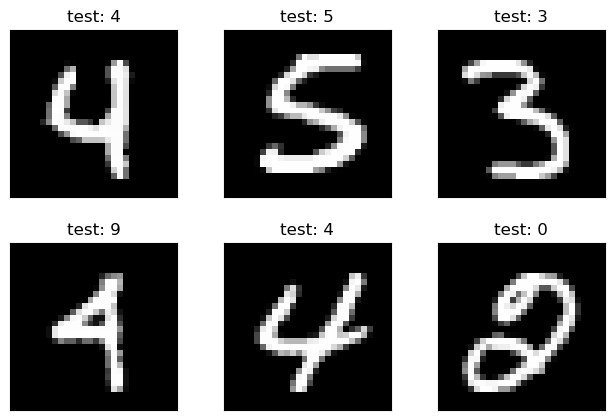

In [6]:

train_loader, test_loader = load_dataset()
x, y = next(iter(train_loader))
# print(x.shape, y.shape, x.min(), x.max())
# plot_image(x, y, "image sample")

net = Net() #调用Net类
# [w1, b1, w2, b2, w3, b3]
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)  #定义优化器，参数说明：net.parameters()表示优化的参数。

epoch_num = 1   #训练次数1
train_loss = train(epoch_num, train_loader, net, optimizer) #训练返回loss

plot_curve(train_loss)  #绘制下降曲线
# 得到参数[w1, b1, w2, b2, w3, b3]

total_correct = 0   #初始化一个变量，用于记录正确的个数
for x, y in test_loader:
    x = x.view(x.size(0), 28 * 28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)    #返回最大值的索引
    correct = pred.eq(y).sum().float().item()   #计算正确的个数，eq()比较两个tensor是否相等，sum()求和，float()转换为浮点数，item()返回元素值
    total_correct += correct    #累加正确的个数

total_num = len(test_loader.dataset)    #测试集的总数
acc = total_correct / total_num #计算准确率
print('test acc:', acc)

x, y = next(iter(test_loader))  #取出一个batch的数据，iter()返回一个迭代器，next()返回迭代器的下一个项目？？
out = net(x.view(x.size(0), 28 * 28))   #预测，此时out是一个tensor，存储的是一组预测值，每个值是一个10维的向量
pred = out.argmax(dim=1)    #取出预测值中最大的索引，即预测的类别
plot_image(x, pred, 'test') #绘制图像